## Thinking in xarray
**22 Febrary 2020 by MiniUFO**

---
[TOC]

---
### 1. 背景
为什么python语言适合大数据分析？嗯，我也在思考。目前的理解是，语言机制上提供了几十个双下划线（__）开头和结尾的函数供程序员重载（重新定义和编写内容），使得程序员自定义到数据结构可以很容易的进行切片、遍历、甚至代数计算。这些类似运算符重载的机制c++也有，但是c++过于复杂且容易出错，所以，吸取了适合大数据科学计算的一些优秀机制后，python开始逆袭了（实际上它的速度还是比较慢的）……

numpy的目标就是在底层用c语言的速度实现python的科学计算，但是它的缺点是多维数组没有名称，只有记住维度的顺序，这常常给程序员带来困扰，不记得第几维代表啥了。我就是这样的人，特别是不同语言的多维数组常常相反。例如FORTRAN语言中经常用的二维数组是row major还是column major（python也有c还是fortran形式的存放顺序），就是指最左边的维度在内存中是连续还是最右边的纬度是连续的。xarray通过对维度、坐标与数据进行绑定，带来不一样的世界。

以前用GrADS的时候，一个二进制文件需要一个ctl文件来描述二进制文件的维数，经向、纬向多少网格，垂向多少网格，时间多少网格等。NetCDF则把这个信息集成到了二进制文件中，称之为头信息（header）。好处是一个数据一个文件，self-descriptive，并且不同维数的变量也能存一起。这里已经隐约看到把维度坐标绑定到数据上的好处。

xarray把这一点进行到了极致。底层是numpy，但是维度有名称，比如时间time，这样可以在做平均的时候，API设计成`data_mean = data.mean(dim='time')`，表明沿着时间维度做平均，这样肯定比numpy的`data_mean = data.mean(dim=dim_0)`要好得多，因为很快我们就不记得dim_0是经度还是时间还是层次。用xarray的话两个月后或者两年后你来看代码还是知道自己在做啥的（不可否认我经常不知道自己的代码做了啥）。

### 2. 绑定维度坐标带来的好处
大气海洋学中的数据通常是多维数组，对应于xarray.DataArray，或者numpy的ndarray。我以前用Java的时候设计过这样的类，本质就是一个四维数组，三维空间加一维时间。但是慢慢发觉不够用，某些情况无法涵盖。比如GrADS里面有第五维ensemble，特别是现在集合预报流行了以后，多了这样一维。再比如我现在做的等值线分析，多了一维等值线空间。这些都无法用传统的四维空间描述，因此，numpy的ndarray和xarray.DataArray就具有更广泛的代表性。

xarray绑定了数据和维度坐标后，带来了几方面的好处，下面分别介绍几个我已经深刻体会到的。

##### 2.1 画图
用过matlab的人都知道画一张温度平面图一般要提供三个参数，经度、纬度、温度，然后用`pcolor(lon, lat, air)`出图。本质上这就是没有做temp上绑定lon、lat坐标的不便之处。绑定后的python代码就是`air.plot()`。下面小试牛刀：

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
[3869000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]


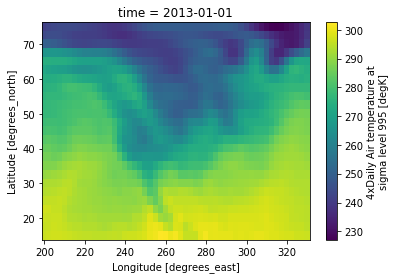

In [3]:
import xarray as xr

# 打开xarray自带的气温数据
dset = xr.tutorial.open_dataset('air_temperature')

air = dset['air']

print(air)

# 画第一个时刻的平面图
air[0].plot()

从打印的信息可以清楚看到，air是一个xarray.DataArray，并且有三维，分别是时间、纬度和经度，具体坐标也都打印了一部分。画图也十分简单，这得益于DataArray已经绑定了坐标信息。

##### 2.2 用差分求导数
大气海洋计算经常要用到差分法计算变量的偏导数。比如$\partial u/\partial x$或者$\partial_x u$，表示$u$沿$x$方向的偏导数（上个例子中x就是经度lon）。由于绑定了坐标信息，计算代码就一句话（这里的差分结果单位是K/经度，要转换成K/m需要额外处理）：

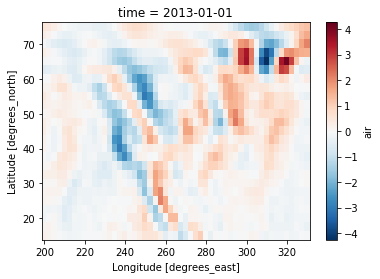

In [6]:
dTdx = air.differentiate('lon')

dTdx[0].plot() # 画第一个时刻，对应上图

### References
[https://dask.org/](https://dask.org/)

[http://xarray.pydata.org/en/stable/](http://xarray.pydata.org/en/stable/)

In [7]:
air.differentiate?